<a href="https://www.kaggle.com/code/mattymyers22/a-titanic-rite-of-passage?scriptVersionId=105434677" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 5 Classification Models for Prediciting Survival with the Titanic Dataset in R

* [Introduction](#section-one)
* [Data Preparation](#section-two)
* [Feature Engineering](#section-three)
* [Model Building](#section-four)
* [Predictions](#section-five)

<a id="section-one"></a>
# Introduction
Welcome to another episode of Kaggle Titanic dataset. As I often hear how overused the Titanic Dataset is, it seems to be a rite of passage to complete this on one's Data Science journey. Our goal here is to gain experience building five different classification models for Survival in the Titanic dataset, then pick the best. To do that we'll spend more time focusing on the model building and less on feature engineering.

Any feedback and upvotes are greatly appreciated.

There are a few shout-outs owed to those who aided along this process. Ideas were used from each of the projects below while bulding these models.

* Ken Jee https://youtu.be/I3FBJdiExcg
* Meg Risdal https://www.kaggle.com/code/mrisdal/exploring-survival-on-the-titanic
* Data Science Dojo
    + Part 1: https://youtu.be/Zx2TguRHrJE
    + Part 2: https://youtu.be/qpihk7KepDI


### Problem
Passenger data is given of those who embarked on the famous Titanic voyage. With a large amount of the passengers not returning from the journey, we are tasked with building a model to help predict whether or not a passenger survived.

<a id="section-two"></a>
# Data Preparation

### Load Package

We'll load libraries as we go to better understand what each is used for.

In [1]:
library('dplyr') # for data manipulation


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Load in the data
Kaggle already has our train and test sets prepared. Let's load them into their own dataframes.

In [2]:
# create dataframe for training set
train.data <- read.csv('../input/titanic/train.csv', stringsAsFactors = T)
# create df for test set
test.data <- read.csv('../input/titanic/test.csv', stringsAsFactors = T)

We'll combine these dataframes to make it easier to clean all of the data at once. Later when we're training our models to make predictions with the test set, we'll need to seperate these dataframes again. Let's add a True/False column first to make that process easier.

In [3]:
# add training column with True to train.data
train.data$training <- TRUE

# add training column with False to test.data
test.data$training <- FALSE

Now we can view the structure of our data.

In [4]:
# check structure of training set
str(train.data)

'data.frame':	891 obs. of  13 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...
 $ training   : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


There are a few columns that aren't as self explanatory as others. 

- Survived: 0 = No and 1 = Yes
- Pclass: ticket class (1st, 2nd, 3rd)
- SibSp: number of siblings / spouses aboard the ship
- Parch: numbuer of parents / children aboard
- Embarked: location passenger embarked from (C = Cherbourg, Q = Queenstown, S = Southampton)

In [5]:
# check structure of test set
str(test.data)

'data.frame':	418 obs. of  12 variables:
 $ PassengerId: int  892 893 894 895 896 897 898 899 900 901 ...
 $ Pclass     : int  3 3 2 3 3 3 3 2 3 3 ...
 $ Name       : Factor w/ 418 levels "Abbott, Master. Eugene Joseph",..: 210 409 273 414 182 370 85 58 5 104 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 2 2 1 2 1 2 1 2 ...
 $ Age        : num  34.5 47 62 27 22 14 30 26 18 21 ...
 $ SibSp      : int  0 1 0 0 1 0 0 1 0 2 ...
 $ Parch      : int  0 0 0 0 1 0 0 1 0 0 ...
 $ Ticket     : Factor w/ 363 levels "110469","110489",..: 153 222 74 148 139 262 159 85 101 270 ...
 $ Fare       : num  7.83 7 9.69 8.66 12.29 ...
 $ Cabin      : Factor w/ 77 levels "","A11","A18",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 2 3 2 3 3 3 2 3 1 3 ...
 $ training   : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...


Thanks to bind_rows() in the dplyr package, we don't need to create the Survived column in the test set, even though it's missing, before combining the two dataframes.

In [6]:
# bind rows of train with test sets and save as new df
full.data <- bind_rows(train.data, test.data)

# confirm NA in Survived column for number of rows in the test set(418)
full.data %>%
    filter(is.na(Survived)) %>%
    nrow()

[1] 418

There are a couple of variables that are listed as integers, and we need to change them to factors as they are categorical variables. This will be for Survived and Pclass.

In [7]:
# set survived column to factor
full.data$Survived <- as.factor(full.data$Survived)

# set Pclass column to factor
full.data$Pclass <- as.factor(full.data$Pclass)

# check structure of full.data for changes
str(full.data)

'data.frame':	1309 obs. of  13 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 187 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...
 $ training   : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


### Finding Missing Values

In [8]:
# summarize full.data to find any NA's
summary(full.data)

  PassengerId   Survived   Pclass                                Name     
 Min.   :   1   0   :549   1:323   Connolly, Miss. Kate            :   2  
 1st Qu.: 328   1   :342   2:277   Kelly, Mr. James                :   2  
 Median : 655   NA's:418   3:709   Abbing, Mr. Anthony             :   1  
 Mean   : 655                      Abbott, Mr. Rossmore Edward     :   1  
 3rd Qu.: 982                      Abbott, Mrs. Stanton (Rosa Hunt):   1  
 Max.   :1309                      Abelson, Mr. Samuel             :   1  
                                   (Other)                         :1301  
     Sex           Age            SibSp            Parch            Ticket    
 female:466   Min.   : 0.17   Min.   :0.0000   Min.   :0.000   CA. 2343:  11  
 male  :843   1st Qu.:21.00   1st Qu.:0.0000   1st Qu.:0.000   1601    :   8  
              Median :28.00   Median :0.0000   Median :0.000   CA 2144 :   8  
              Mean   :29.88   Mean   :0.4989   Mean   :0.385   3101295 :   7  
     

With the summary() function, we can see that there are NA's within the columns Survived, Age, and Fare. We don't need to worry about the Survived NA's until we perform our predictions. 

The factored columns of Embarked and Cabin appear to have some blank datapoints. Let's start with Embarked as there are only two blank entries.

Seeing 1014 missing values for cabin, we'll opt to disregard that variable as a feature in our models.

### Categorical Imputation

We'll take a look at the rows with a missing a value for Embarked.

In [9]:
# filter for rows where Embarked value is empty
filter(full.data, Embarked == "")

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,training
<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<lgl>
62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,,TRUE
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,,TRUE


Both of these ladies have the same cabin, fare, ticket number, and are in 1st class. Let's dig into some of the variable distributions for the various ports of embarkation.

In [10]:
# create dataframe without the two passengers above
embark_true <- full.data %>%
    filter(PassengerId != 62 & PassengerId != 830)

# count passengers by class and embarked
embark_true %>%
    group_by(Embarked, Pclass) %>%
    count()

Embarked,Pclass,n
<fct>,<fct>,<int>
C,1,141
C,2,28
C,3,101
Q,1,3
Q,2,7
Q,3,113
S,1,177
S,2,242
S,3,495


Just by the count of passengers for embarked and class, we see that it's more likely these two passengers departed from Cherbourg or Southampton. Let's see if we can pull more insight by the fare distributions for these groups.

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


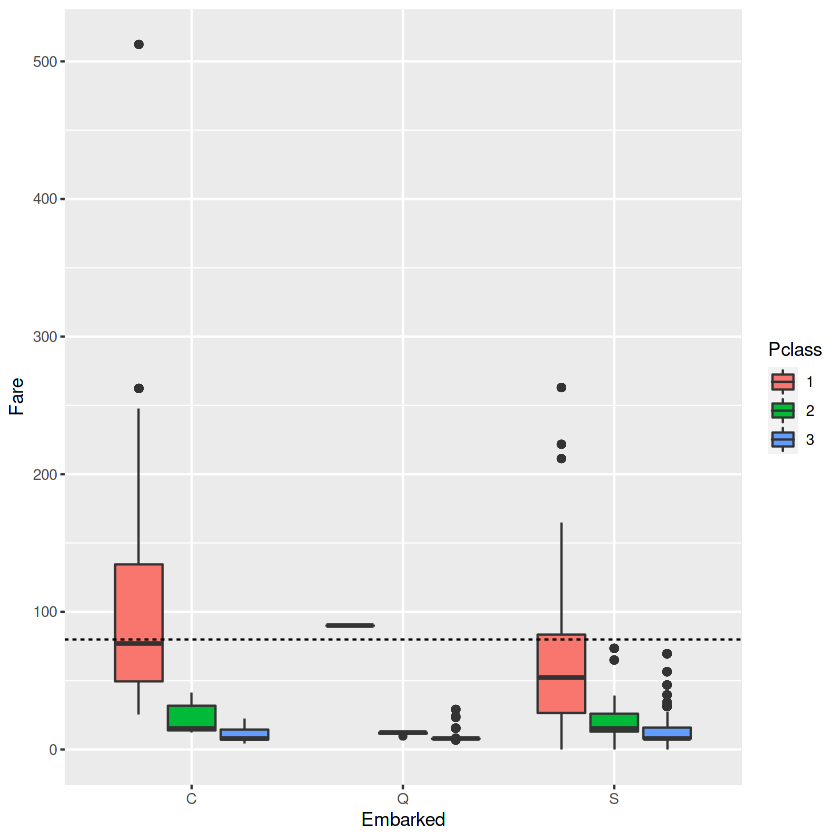

In [11]:
library(ggplot2) # for visualizations

# boxplot of fare by embarked and passenger class
ggplot(embark_true, aes(Embarked, Fare, fill = Pclass)) +
    geom_boxplot() +
    # visualize the $80 fare for our two missing passengers
    geom_hline(aes(yintercept = 80), linetype = "dashed")

By comparing the fare of our passengers missing a port of embarkedment, we see that their tickets are similar to the median of 1st class passengers departing from Cherbourg. Let's impute "C" for their port.

In [12]:
# assign C as Embarked for passengers 62 and 830
full.data[c(62,830), "Embarked"] <- 'C'

# check to see corrections made
full.data[c(62, 830),]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,training
,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<lgl>
62,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,C,TRUE
830,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,C,TRUE


### Numerical Imputation

Now we need some imputation for Age and Fare. With both of these features being numeric variables, let's use some regression to predict these missing values. As Fare only has one missing value, while Age has many, we'll start with age so there aren't many NA's omitted for building the age model.

In [13]:
# count missing Age data
full.data %>%
    filter(is.na(Age)) %>%
    nrow()

[1] 263

Due to cabin having many missing values and ticket number likely not adding any value in predicting the age of passengers, we'll use the remaining features (besides Survived) to build a regression model for predicting age of those 263 passengers.

Let's opt to use the Ordinary Least Squares regression method as it is a simple and effective method. OLS regression is susceptible to outliers, we'll see if there are any to worry about.

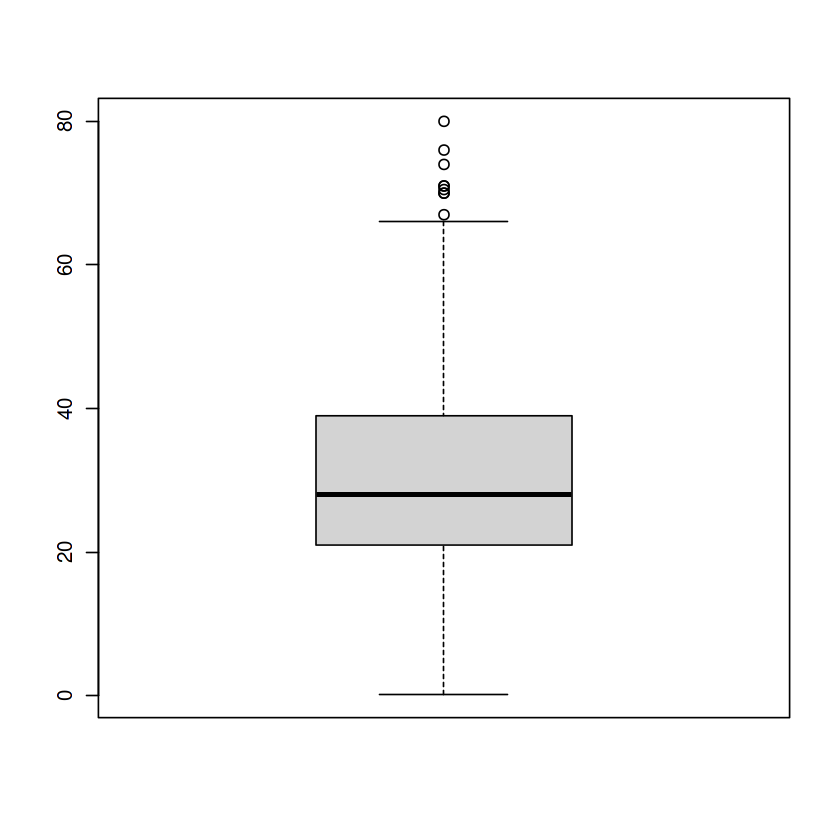

In [14]:
# boxplot of age data
boxplot(full.data$Age)

There appears to be outliers at the higher end of the age range. Let's pull the boxplot stats so we can find our age cut off.

In [15]:
# boxplot stats to find upper whisker of plot
boxplot.stats(full.data$Age)

$stats
[1]  0.17 21.00 28.00 39.00 66.00

$n
[1] 1046

$conf
[1] 27.12065 28.87935

$out
[1] 71.0 70.5 71.0 80.0 70.0 70.0 74.0 67.0 76.0

We'll extract that upper whisker threshold to create a dataframe filtered for ages less than or equal to 66 for training our model.

In [16]:
# create variable to hold upper whisker bound
upper_whisker <- boxplot.stats(full.data$Age)$stats[5]

# create dataframe of passengers with Age <= upper_whisker
filtered.age <- full.data$Age <= upper_whisker

# check summary stats of filtered data
summary(full.data[filtered.age, ]$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.17   21.00   28.00   29.51   38.00   66.00     263 

We can confirm that filtered age data has a max of 66. Let's train our age regression model using the variables Pclass, Sex, SibSp, Parch, Fare, and Embarked.

In [17]:
# create age equation
age_equation = "Age ~ Pclass + Sex + SibSp + Parch + Fare + Embarked"

# build linear regression model
age.model <- lm(formula = age_equation, data = full.data[filtered.age,])

With the model trained, now we need to use it for making predictions with the data where Age is NA.

In [18]:
# filter for NA Age and columns needed for fare model
age.predictor.columns <- full.data[is.na(full.data$Age), 
                                   c("Pclass", "Sex", 
                                     "SibSp", "Parch", 
                                     "Fare", "Embarked")]

# make age predictions
age_prediction <- predict(age.model, newdata = age.predictor.columns)

# assign age predictions
full.data[is.na(full.data$Age), "Age"] <- age_prediction

# check summary stats for age data
summary(full.data$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -1.783  22.000  27.441  29.432  36.000  80.000 

There are no more NA's for age, yet we have some negative values that the model predicted. This isn't realistic. Let's impute for those the minimum age greater than 0. 

In [19]:
# save minimum age for ages > 0
min_age <- full.data %>%
    filter(Age > 0) %>%
    summarize(min = min(Age))

# replace age values of 0 or less with min_age (0.17)
full.data[full.data$Age <= 0, "Age"] <- min_age

# check Age stats
summary(full.data$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.17   22.00   27.44   29.44   36.00   80.00 

The age predictions are imputed into full.data. Now to impute the missing Fare value.

In [20]:
# view missing Fare datapoint
full.data[is.na(full.data$Fare),]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,training
,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<lgl>
1044,1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,FALSE


Let's see if there are any outliers with the Fare data before building that model.

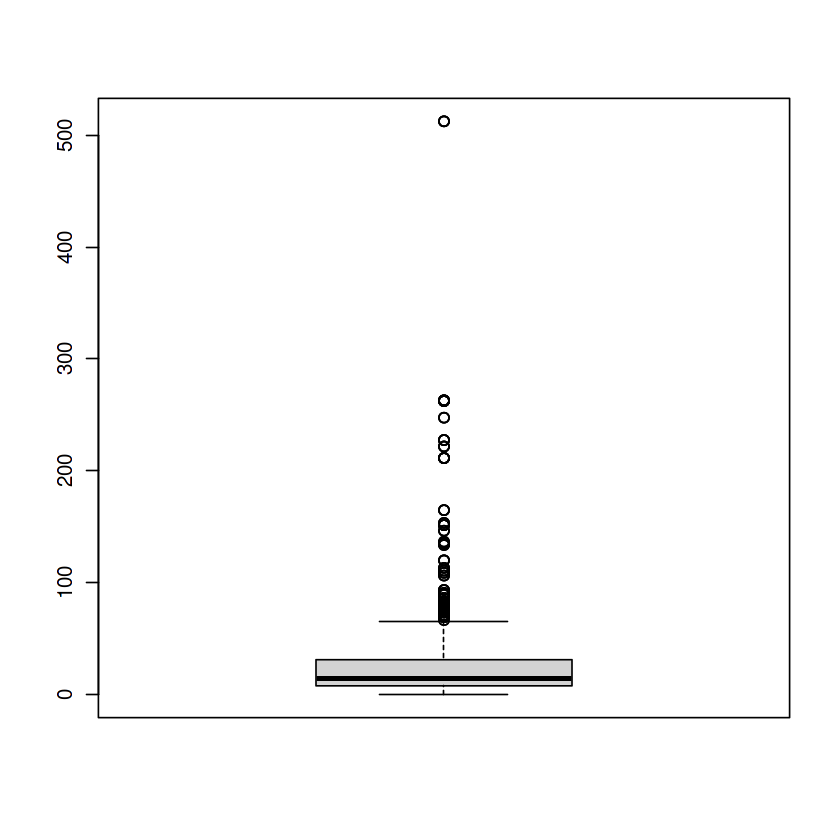

In [21]:
# view boxplot for Fare
boxplot(full.data$Fare)

We can see that there are quite a few outliers when it comes to fare. With our missing fare individual being in the 3rd class, we shouldn't need the regression model weighted too much on higher priced tickets. Let's filter out the outliers from this regression model.

In [22]:
# boxplot stats to find upper whisker of plot
boxplot.stats(full.data$Fare)$stats

[1]  0.0000  7.8958 14.4542 31.2750 65.0000

We'll create a dataframe that only uses data with a fare price under that upper threshold of 65 for training our Fare prediction model.

In [23]:
# create variable to hold upper whisker bound
upper_whisker <- boxplot.stats(full.data$Fare)$stats[5]

# create dataframe of passengers with Fare <= upper_whisker
filtered.fare <- full.data$Fare <= upper_whisker

# check summary stats of filtered data
summary(full.data[filtered.fare, ]$Fare)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   7.879  13.000  17.962  26.000  65.000       1 

Filtered fare data has a max of 65. Let's build our fare regression model using the variables Pclass, Sex, Age, SibSp, Parch, and Embarked.

In [24]:
# create fare equation
fare_equation = "Fare ~ Pclass + Sex + Age + SibSp + Parch + Embarked"

# build linear regression model
fare.model <- lm(formula = fare_equation, data = full.data[filtered.fare,])

Now to select the data of interest in order to perform our prediction and save it back into full.data.

In [25]:
# filter for NA Fare and columns needed for fare model
fare.predictor.columns <- full.data[is.na(full.data$Fare), c("Pclass", "Sex", 
                                                             "Age", "SibSp", 
                                                             "Parch", "Embarked")]

# make fare prediction for passenger 1044
fare_prediction <- predict(fare.model, newdata = fare.predictor.columns)

# assign fare prediction for passenger 1044
full.data[is.na(full.data$Fare), "Fare"] <- fare_prediction

# round fare prediction to two digits and check data entry
full.data[1044, "Fare"] <- round(full.data[1044, "Fare"], digits = 2)
full.data[1044,]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,training
,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<lgl>
1044,1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,7.68,,S,FALSE


Our missing data is taken care of. We can now move on to the feature engineering and model building.

<a id="section-three"></a>
# Feature Engineering

Again, for this project we're focusing more on the act of training various types of models for classification and comparing their results. Instead of deep diving into many of the different ways to feature engineer this problem, we'll keep it simple to have more time to focus on building the different types of models.

As we did with our regression models for imputation, we'll leave out Cabin and Ticket from our classification models. This is due to Cabin having many missing values and ticket number likely being random.

### Future Ideas

It is important to note some possible areas for future exploration with feature engineering in this problem set. One area of exploration could be how missing values could potentially be an indicator of survivability.

In [26]:
# view counts of missing and non-missing cabin by Survived in train.data
train.data %>%
    filter(Cabin == "") %>%
    group_by(Survived) %>%
    count()

Survived,n
<int>,<int>
0,481
1,206


We can see that within the training dataset, there is a high proportion of passengers that had a blank value for Cabin and who did not survive. It could be that passengers who have any missing values for features are more likely to be those who didn't return from the voyage.

<a id="section-four"></a>
# Model Building

We'll use five different types of classification models to choose from when making our final predictions. These models are:
* Logistic Regression
* Naive Bayes
* Decision Tree
* Random Forest
* K Nearest Neighbor

Each model will use the same formula that we will create below. We'll also need to split our cleaned full.data back into their respective train and test sets.

In [27]:
# create Survived equation for model building
survived_equation <- as.formula("Survived ~ Pclass + Sex + SibSp + Parch + 
    Fare + Embarked + Age")

# create dataframe of cleaned training set
clean.training <- full.data %>%
    filter(training == TRUE) %>%
    select(-c(Name, Ticket, Cabin, training))

# check for 891 rows and desired columns of clean training data
str(clean.training)

'data.frame':	891 obs. of  9 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


In [28]:
# create dataframe of cleaned test data
clean.test <- full.data %>%
    filter(training == FALSE) %>%
    select(-c(Survived, Name, Ticket, Cabin, training))

# check for 418 rows of clean test data
str(clean.test)

'data.frame':	418 obs. of  8 variables:
 $ PassengerId: int  892 893 894 895 896 897 898 899 900 901 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 3 2 3 3 3 3 2 3 3 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 2 2 1 2 1 2 1 2 ...
 $ Age        : num  34.5 47 62 27 22 14 30 26 18 21 ...
 $ SibSp      : int  0 1 0 0 1 0 0 1 0 2 ...
 $ Parch      : int  0 0 0 0 1 0 0 1 0 0 ...
 $ Fare       : num  7.83 7 9.69 8.66 12.29 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 3 4 3 4 4 4 3 4 2 4 ...


For the sake of cleanliness, let's fix the factor levels for Embarked to 3 now that we've replaced the missing value. To do that, we'll need to change the column type to character and back to a factor.

In [29]:
# change Embarked column to character type for clean.training
clean.training$Embarked <- as.character(clean.training$Embarked)

# change Embarked column back to factor to reset levels
clean.training$Embarked <- as.factor(clean.training$Embarked)
str(clean.training)

'data.frame':	891 obs. of  9 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


In [30]:
# change Embarked column to character type for clean.test
clean.test$Embarked <- as.character(clean.test$Embarked)

# change Embarked column back to factor to reset levels
clean.test$Embarked <- as.factor(clean.test$Embarked)
str(clean.test)

'data.frame':	418 obs. of  8 variables:
 $ PassengerId: int  892 893 894 895 896 897 898 899 900 901 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 3 2 3 3 3 3 2 3 3 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 2 2 1 2 1 2 1 2 ...
 $ Age        : num  34.5 47 62 27 22 14 30 26 18 21 ...
 $ SibSp      : int  0 1 0 0 1 0 0 1 0 2 ...
 $ Parch      : int  0 0 0 0 1 0 0 1 0 0 ...
 $ Fare       : num  7.83 7 9.69 8.66 12.29 ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 2 3 2 3 3 3 2 3 1 3 ...


Our data and formula is prepped, now let's build some models.

### Logistic Regression

We'll start with a logistic regression model. Our models will be looking to predict either a 1 for Survived or 0 for Not Survived.

In [31]:
# build logistic regression model with clean training data
log_reg <- glm(survived_equation, data = clean.training, family = "binomial")

Logistic Regression model built, on to the next one.

### Naive Bayes

To build a Bayesian model, we'll need to load the desired package.

In [32]:
# load naivebayes package
library(naivebayes)

naivebayes 0.9.7 loaded



Now we'll build the model, training it with our clean training set.

In [33]:
# build bayes model with clean.training data
bayes <- naive_bayes(survived_equation, data = clean.training)

Naive Bayes built and trained.

### Decision Tree

For building and training a decision tree model, we'll need to load the rpart package.

In [34]:
# load the rpart library for classification tree model
library(rpart)

With the package loaded, we can use the rpart() function with method = "class" to train our classification decision tree model.

In [35]:
# build classification tree model
decTree <- rpart(survived_equation, data = clean.training, 
                 method = "class")

Decision Tree mode built.

### Random Forest

Let's load the randomForest library for building our model.

In [36]:
# load randomForest library
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine




For our random forest model, we'll keep the ntree (number of trees to grow) at 500 which is common practice. For mtry (number of variables randomly sampled as candidates at each split) we have to set it as sqrt(p) for classification problems. Where p is the number of our dependent/predictor variables, this gives sqrt(7) = 2.645 round up to 3.

In [37]:
rand_for <- randomForest(survived_equation, data = clean.training,
                         ntree = 500, mtry = 3)

Random Forest planted, lastly is KNN.

### K Nearest Neighbors

To build a K Nearest Neighbors model, we'll need the "class" package.

In [38]:
# load class library
library(class)

As a K Nearest Neighbor (KNN) model looks to calculate the difference between data points, it won't like our factor variables that don't have quantifiable distances. Let's create some dummy variables for each factor level showing either a 1 or 0.

In [39]:
# pull Survived values for training set
train.labels <- clean.training[ ,'Survived']

# create knn training dataframe with desired columns (not Survived)
knn.training <- clean.training %>%
    select(Pclass, Sex, SibSp, Parch, Fare, Embarked, Age)

# create dummy variables for factors
knn.training <- knn.training %>%
    # create our dummy variables for each factor type/level
    mutate(Male = as.integer(ifelse(Sex == 'male', 1, 0)),
           Female = as.integer(ifelse(Sex == 'female', 1, 0)),
           Cherbourg = as.integer(ifelse(Embarked == 'C', 1, 0)),
           Queenstown = as.integer(ifelse(Embarked == 'Q', 1, 0)),
           Southampton = as.integer(ifelse(Embarked == 'S', 1, 0)),
           FirstClass = as.integer(ifelse(Pclass == '1', 1, 0)),
           SecondClass = as.integer(ifelse(Pclass == '2', 1, 0)),
           ThirdClass = as.integer(ifelse(Pclass == '3', 1, 0))) %>%
    # select desired columns
    select(SibSp, Parch, Fare, Age, Male, Female, Cherbourg, Queenstown,
           Southampton, FirstClass, SecondClass, ThirdClass)

# check dataframe
head(knn.training)

,SibSp,Parch,Fare,Age,Male,Female,Cherbourg,Queenstown,Southampton,FirstClass,SecondClass,ThirdClass
,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0,7.2500,22.0000,1,0,0,0,1,0,0,1
2,1,0,71.2833,38.0000,0,1,1,0,0,1,0,0
3,0,0,7.9250,26.0000,0,1,0,0,1,0,0,1
4,1,0,53.1000,35.0000,0,1,0,0,1,1,0,0
5,0,0,8.0500,35.0000,1,0,0,0,1,0,0,1
6,0,0,8.4583,29.3778,1,0,0,1,0,0,0,1


With our training set done, we'll need to do the same for the test set.

In [40]:
# create knn test set data frame with desired features
knn.test <- clean.test %>%
    select(Pclass, Sex, SibSp, Parch, Fare, Embarked, Age)

# create dummy variables for factors
knn.test <- knn.test %>%
    # create dummy variable columns
    mutate(Male = as.integer(ifelse(Sex == 'male', 1, 0)),
           Female = as.integer(ifelse(Sex == 'female', 1, 0)),
           Cherbourg = as.integer(ifelse(Embarked == 'C', 1, 0)),
           Queenstown = as.integer(ifelse(Embarked == 'Q', 1, 0)),
           Southampton = as.integer(ifelse(Embarked == 'S', 1, 0)),
           FirstClass = as.integer(ifelse(Pclass == '1', 1, 0)),
           SecondClass = as.integer(ifelse(Pclass == '2', 1, 0)),
           ThirdClass = as.integer(ifelse(Pclass == '3', 1, 0))) %>%
    # select desired columns
    select(SibSp, Parch, Fare, Age, Male, Female, Cherbourg, Queenstown,
           Southampton, FirstClass, SecondClass, ThirdClass)

# check data
head(knn.test)

,SibSp,Parch,Fare,Age,Male,Female,Cherbourg,Queenstown,Southampton,FirstClass,SecondClass,ThirdClass
,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,7.8292,34.5,1,0,0,1,0,0,0,1
2,1,0,7.0000,47.0,0,1,0,0,1,0,0,1
3,0,0,9.6875,62.0,1,0,0,1,0,0,1,0
4,0,0,8.6625,27.0,1,0,0,0,1,0,0,1
5,1,1,12.2875,22.0,0,1,0,0,1,0,0,1
6,0,0,9.2250,14.0,1,0,0,0,1,0,0,1


The function knn() builds the model and makes predictions in one go. We'll put that together down below when making our predictions.

<a id="section-five"></a>
# Predictions

Something to keep in mind is a baseline for judging our model performance can be the better success rate of just guessing either Survived or Not Survived for our training set.

In [41]:
# percentage of survived vs not survived of training set
train.data %>%
    group_by(Survived) %>%
    count() %>%
    mutate(Prop = n / nrow(train.data))

Survived,n,Prop
<int>,<int>,<dbl>
0,549,0.6161616
1,342,0.3838384


It appears that about 61.6% of the passengers in the training set did not survive. We are looking for models that can show a significant improvement from an overall guess of not survived.

### Model Prediction Breakdown

Added here is a breakdown of the accuracy for each model with the test set. Code for making those predictions is below.
* Logistic Regression: 76.32%
* Naive Bayes: 74.88%
* Decision Tree: 78.47%
* Random Forest: 77.75%
* K Nearest Neighbor: 66.03%

### Logistic Regression

The logistic regression model will make predictions in the form of probabilities between 0 and 1. We'll use an ifelse statement to round those for Survived.

In [42]:
# predict probability of survival with logistic regression model
log.reg.test <- clean.test %>%
    mutate(prob = predict(log_reg, clean.test, type = "response"),
            Survived = ifelse(prob > 0.50, 1, 0))

# check predictions
head(log.reg.test)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,prob,Survived
,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>
1,892,3,male,34.5,0,0,7.8292,Q,0.09918592,0
2,893,3,female,47.0,1,0,7.0000,S,0.30810727,0
3,894,2,male,62.0,0,0,9.6875,Q,0.10867955,0
4,895,3,male,27.0,0,0,8.6625,S,0.09449393,0
5,896,3,female,22.0,1,1,12.2875,S,0.54833659,1
6,897,3,male,14.0,0,0,9.2250,S,0.15490719,0


We need to write the columns PassengerId and Survived to a CSV for submission.

In [43]:
# create dataframe of PassengerID and Survived columns
log.reg.solutions <- log.reg.test %>%
    select(PassengerId, Survived)

# write to csv for submission
write.csv(log.reg.solutions, file = "log_reg_solutions.csv", row.names = FALSE)

Results for this model gives a 0.76315 or 76.32% accuracy.

### Naive Bayes

Let's create a dataframe containing predictions from our Naive Bayes model.

In [44]:
# create solutions data frame with predictions from bayes model
bayes.solutions <- clean.test %>%
    mutate(Survived = predict(bayes, clean.test))

Warning message:
“predict.naive_bayes(): more features in the newdata are provided as there are probability tables in the object. Calculation is performed based on features to be found in the tables.”


This warning message is bringing to our attention that the columns within clean.test are greater than the probability tables in our model. This is due to the PassengerId column within clean.test and not being within our formula for the model. Calculations are based on the features within the model.

In [45]:
# select the columns PassengerId and Survived for submission
bayes.solutions <- bayes.solutions %>%
    select(PassengerId, Survived)

With the dataframe containing just PassengerId and Survived predictions for the Bayes mode, we'll write it to the CSV for submission.

In [46]:
# write to csv for submission
write.csv(bayes.solutions, file = "bayes_solutions.csv", row.names = FALSE)

Predictions from this Naive Bayes model gave an accuracy of 0.7488 or 74.88%.

### Decision Tree

We can use the predict() function again with the Decision Tree model for our predictions.

In [47]:
# make predictions with decision tree model
dec.tree.test <- clean.test %>%
    mutate(Survived = predict(decTree, clean.test, type = "class"))

# check Survived predictions
head(dec.tree.test)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>,<fct>
1,892,3,male,34.5,0,0,7.8292,Q,0
2,893,3,female,47.0,1,0,7.0000,S,0
3,894,2,male,62.0,0,0,9.6875,Q,0
4,895,3,male,27.0,0,0,8.6625,S,0
5,896,3,female,22.0,1,1,12.2875,S,1
6,897,3,male,14.0,0,0,9.2250,S,0


Now to write our results to a CSV for submission.

In [48]:
# create dataframe of PassengerID and Survived columns
dec.tree.solutions <- dec.tree.test %>%
    select(PassengerId, Survived)

# write to csv for submission
write.csv(dec.tree.solutions, file = "dec_tree_solutions.csv", row.names = FALSE)

Results for this model gives a 0.78468 or 78.47% accuracy.

### Random Forest

Let's make predictions with our Random Forest.

In [49]:
# make predictions with Random Forest model
rand.for.test <- clean.test %>%
    mutate(Survived = predict(rand_for, clean.test))

# check Survived predictions
head(rand.for.test)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>,<fct>
1,892,3,male,34.5,0,0,7.8292,Q,0
2,893,3,female,47.0,1,0,7.0000,S,0
3,894,2,male,62.0,0,0,9.6875,Q,0
4,895,3,male,27.0,0,0,8.6625,S,0
5,896,3,female,22.0,1,1,12.2875,S,1
6,897,3,male,14.0,0,0,9.2250,S,0


And write those predictions to a CSV.

In [50]:
# create data frame with PassengerId and Survived
rand.for.solutions <- rand.for.test %>%
    select(PassengerId, Survived)

# write to csv for submission
write.csv(rand.for.solutions, file = "rand_for_solutions.csv", row.names = FALSE)

Results for this model gives a 0.77751 or 77.75% accuracy.

### K Nearest Neighbors

Lastly is the K Nearest Neighbors model predictions.

In [51]:
# make predictions with knn()
knn.pred <- clean.test %>%
    mutate(Survived = knn(train = knn.training, test = knn.test, 
                          cl = train.labels, k = 30))

Write.csv() those predictions.

In [52]:
# create dataframe with just PassengerId and KNN predictions
knn.pred <- knn.pred %>%
    select(PassengerId, Survived)

# write to csv for submission
write.csv(knn.pred, file = "knn_solutions.csv", row.names = FALSE)

Results for this model gives an accuracy of 0.66028 or 66.03%

### Thank You!

If you've made it this far, thank you so much for your time. I wish you the very best in your journey ahead :)